# SVM Property Address Classification 

## Objective
Implement a SVM classifier with:
- Exact preprocessing (keep numbers, punctuation)
- Word + Character TF-IDF (FeatureUnion)
- Pipeline architecture (no data leakage)
- Cross-validation with proper metrics
- Complete evaluation suite

## Import libraries

In [ ]:
!pip install pandas numpy scikit-learn matplotlib seaborn openpyxl


In [1]:
import pandas as pd
import numpy as np
import re
import warnings
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             f1_score, precision_score, recall_score)

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print(" Imports complete")

 Imports complete


## Loading and inspecting the dataset
#### Reading Excel files, extracting inputs/labels, and displaying class distribution


In [8]:
# Load data
train_df = pd.read_excel("../data/Training.xlsx")
val_df = pd.read_excel("../data/Validation.xlsx")

X_train_raw = train_df["property_address"].values
X_val_raw = val_df["property_address"].values
y_train = train_df["categories"].values
y_val = val_df["categories"].values

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"\nClass distribution (Training):")
print(train_df["categories"].value_counts())

Training samples: 8936
Validation samples: 2681

Class distribution (Training):
categories
flat               3232
houseorplot        2673
others             1197
commercial unit     965
landparcel          869
Name: count, dtype: int64


## Preprocessing pipeline

**Expanded Canonicalization (High-Impact Improvements)**

### **Critical Keywords (Directly Improves Classification):**

#### **A. Khasra Variants**
- `kh no`, `kh.no`, `khno` → `khasra`
- `khasr`, `khasa`, `khasra` → `khasra`
- `khata no` → `khasra`
- `k no`, `k.no`, `kno` → `khasra`

**Impact:** Reduction in landparcel misclassifications

#### **B. Survey No Variants** *(Important for landparcel/houseorplot)*
- `s no`, `s.no`, `sno` → `surveyno`
- `sy no`, `sy.no` → `surveyno`
- `sur no`, `srv no`, `sry no` → `surveyno`

**Impact:** Better separation between landparcel and houseorplot

#### **C. Plot No Variants** *(Important for houseorplot)*
- `p no`, `p.no`, `pno` → `plotno`
- `plt no` → `plotno`
- `plot #` → `plotno`

**Impact:** Cleaner feature space for plot-based addresses

#### **D. House No Variants** *(Important for flat/houseorplot)*
- `h no`, `h.no`, `hno`, `h-no` → `houseno`
- `ho no`, `hs no` → `houseno`

**Impact:** Better flat vs houseorplot distinction

### **What is retained:**
-  All numbers (no _NUM_ replacement)
-  Punctuation: `/`, `-`, `,`, `.` (address structure)
-  Natural indicators: society, apartments, colony, sector, ward
-  Character patterns (critical for char n-grams)


### **Additional Improvements:**
-  Normalize multiple slashes/hyphens (`///` → `/`, `---` → `-`)
-  Enhanced location indicators (`opp.`, `nr.` → `opposite`, `near`)

In [9]:
def preprocess_address(text):
    
    if pd.isna(text):
        return ""
    
    text = str(text).lower()
    
    
    
    # A. Khasra Variants (CRITICAL for landparcel class)
    khasra_patterns = [
        r"\bkh\.?\s*no\.?\b",        # kh no, kh.no, khno
        r"\bkhas?ra?\b",             # khasra, khasr, khasa
        r"\bkhata\s*no\.?\b",        # khata no
        r"\bkha?sr?a?\s*no\.?\b",    # khasra no, khsra no, etc.
        r"\bk\.?\s*no\.?\b",         # k no, k.no, kno
        r"\bkno\b",                  # kno (common typo)
    ]
    for pattern in khasra_patterns:
        text = re.sub(pattern, " khasra ", text)
    
    # B. Survey No Variants (Important for landparcel/houseorplot distinction)
    survey_patterns = [
        r"\bs\.?\s*no\.?\b",         # s no, s.no, sno
        r"\bsy\.?\s*no\.?\b",        # sy no, sy.no
        r"\bsurvey\s*no\.?\b",       # survey no
        r"\bsurv?ey?\s*no\.?\b",     # survey no, survay no
        r"\bsr?y?\s*no\.?\b",        # sy no, sry no, sno
        r"\bsur\s*no\.?\b",          # sur no
        r"\bsrv\s*no\.?\b",          # srv no
    ]
    for pattern in survey_patterns:
        text = re.sub(pattern, " surveyno ", text)
    
    # C. Plot No Variants (Important for houseorplot/landparcel distinction)
    plot_patterns = [
        r"\bp\.?\s*no\.?\b",         # p no, p.no, pno
        r"\bplt\s*no\.?\b",          # plt no
        r"\bplot\s*no\.?\b",         # plot no
        r"\bplot\s*#\b",             # plot #
    ]
    for pattern in plot_patterns:
        text = re.sub(pattern, " plotno ", text)
    
    # D. House No Variants (Important for flat/houseorplot distinction)
    house_patterns = [
        r"\bh\.?\s*no\.?\b",         # h no, h.no, hno
        r"\bh\-?no\.?\b",            # h-no, hno
        r"\bho\s*no\.?\b",           # ho no
        r"\bhs\s*no\.?\b",           # hs no
        r"\bhouse\s*no\.?\b",        # house no
    ]
    for pattern in house_patterns:
        text = re.sub(pattern, " houseno ", text)
    
    # E. Gata Variants (for landparcel)
    gata_patterns = [
        r"\bgt\.?\s*no\.?\b",        # gt no, gt.no
        r"\bgata\s*no\.?\b",         # gata no
    ]
    for pattern in gata_patterns:
        text = re.sub(pattern, " gata ", text)
    
    
    
    # Floor abbreviations
    text = re.sub(r"\bg\.?\s*f\.?\b", " groundfloor ", text)       # g f, g.f, gf
    text = re.sub(r"\bground\s*floor\b", " groundfloor ", text)
    
    # Location indicators (expanded)
    text = re.sub(r"\bopp\.?\b", " opposite ", text)               # opp, opp.
    text = re.sub(r"\bnr\.?\b", " near ", text)                    # nr, nr.
    text = re.sub(r"\bnear\b", " near ", text)                     # normalize "near"
    
    
    
    # Normalize multiple slashes
    text = re.sub(r"/+", "/", text)                                # /// → /
    
    # Normalize multiple hyphens
    text = re.sub(r"-+", "-", text)                                # --- → -
    
    # Normalize multiple dots
    text = re.sub(r"\.+", ".", text)                               # ... → .
    
    # Remove everything except: a-z, 0-9, /, -, ,, .
    # This preserves:
    # - All numbers (critical for char n-grams)
    # - Address structure punctuation (/, -, ,, .)
    # - Natural indicators (society, apartments, colony, etc. remain as they're alphabets)
    text = re.sub(r"[^a-z0-9/\-,\. ]+", " ", text)
    
    # Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()
    
    return text


# Test preprocessing with various examples

test_cases = [
    "H No 123/45, Plot No. 67, Kh No 89, Opp. Market, G/F",
    "khasra no 456, survey no 789, near railway",
    "Flat 2B, Sunrise Apartments, Society Road",
    "Kno 123, Srv No 456, Plt 789",
    "house no. 45-B, sector 12, colony area",
    "s.no 234/1A, khsra 567, gt no 890"
]

print("PREPROCESSING TEST CASES:")
print("=" * 80)
for original in test_cases:
    cleaned = preprocess_address(original)
    print(f"Original: {original}")
    print(f"Cleaned:  {cleaned}")
    print("-" * 80)

print("Enhanced preprocessing function ready")

PREPROCESSING TEST CASES:
Original: H No 123/45, Plot No. 67, Kh No 89, Opp. Market, G/F
Cleaned:  houseno 123/45, plotno . 67, khasra 89, opposite . market, g/f
--------------------------------------------------------------------------------
Original: khasra no 456, survey no 789, near railway
Cleaned:  khasra 456, surveyno 789, near railway
--------------------------------------------------------------------------------
Original: Flat 2B, Sunrise Apartments, Society Road
Cleaned:  flat 2b, sunrise apartments, society road
--------------------------------------------------------------------------------
Original: Kno 123, Srv No 456, Plt 789
Cleaned:  khasra 123, surveyno 456, plt 789
--------------------------------------------------------------------------------
Original: house no. 45-B, sector 12, colony area
Cleaned:  houseno . 45-b, sector 12, colony area
--------------------------------------------------------------------------------
Original: s.no 234/1A, khsra 567, gt no 890
Cl

## Feature Engineering: Word + Character TF-IDF (FeatureUnion)

- Word TF-IDF captures semantic patterns
- Character TF-IDF captures typos, variations
- Combined = best of both worlds

In [10]:
# A. Word TF-IDF
word_tfidf = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 3),
    max_features=5000,
    min_df=2,
    sublinear_tf=True,
    preprocessor=preprocess_address
)

# B. Character TF-IDF
char_tfidf = TfidfVectorizer(
    analyzer='char',
    ngram_range=(3, 5),
    max_features=3000,
    min_df=2,
    sublinear_tf=True,
    preprocessor=preprocess_address
)

# C. Combine using FeatureUnion
combined_features = FeatureUnion([
    ('word', word_tfidf),
    ('char', char_tfidf)
])

print(" FeatureUnion created (Word + Char TF-IDF)")

 FeatureUnion created (Word + Char TF-IDF)


## LinearSVC Configuration 

**Why these parameters:**
- `C=1.0`: Best for text classification
- `squared_hinge`: Stable + best margins
- `balanced`: Boosts landparcel/others recall
- `max_iter=5000`: Prevents convergence warnings

In [11]:
svm_clf = LinearSVC(
    C=1.0,
    loss="squared_hinge",
    class_weight="balanced",
    max_iter=5000,
    random_state=RANDOM_SEED
)

print("LinearSVC configured")

LinearSVC configured


## Pipeline - Prevents data leakage

TF-IDF must be inside pipeline to avoid fitting on test data

In [12]:
pipeline = Pipeline([
    ('features', combined_features),
    ('clf', svm_clf)
])

print("Pipeline created")
print("\nPipeline structure:")
print(pipeline)

Pipeline created

Pipeline structure:
Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('word',
                                                 TfidfVectorizer(max_features=5000,
                                                                 min_df=2,
                                                                 ngram_range=(1,
                                                                              3),
                                                                 preprocessor=<function preprocess_address at 0x141af8220>,
                                                                 sublinear_tf=True)),
                                                ('char',
                                                 TfidfVectorizer(analyzer='char',
                                                                 max_features=3000,
                                                                 min_df=2,
                                              

## Cross-Validation (Hyperparameter Validation)

**This validates our model on training data before touching validation set**

In [13]:
print("Starting 5-Fold Cross-Validation...\n")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

start_time = time()
cv_scores = cross_val_score(
    pipeline, 
    X_train_raw, 
    y_train, 
    cv=cv, 
    scoring='f1_macro',
    n_jobs=-1
)
cv_time = time() - start_time

print("CROSS-VALIDATION RESULTS")

print(f"Mean CV Macro F1:  {cv_scores.mean():.4f}")
print(f"Std Dev:           {cv_scores.std():.4f}")
print(f"All Folds:         {[f'{s:.4f}' for s in cv_scores]}")
print(f"Training Time:     {cv_time:.2f}s")


# Store for leaderboard
cv_macro_f1 = cv_scores.mean()
cv_std = cv_scores.std()

Starting 5-Fold Cross-Validation...



CROSS-VALIDATION RESULTS
Mean CV Macro F1:  0.8905
Std Dev:           0.0044
All Folds:         ['0.8872', '0.8890', '0.8937', '0.8851', '0.8973']
Training Time:     13.55s


## Train Final Model & Evaluate on Validation Set

In [14]:
print("Training final model on full training set...\n")

start_time = time()
pipeline.fit(X_train_raw, y_train)
train_time = time() - start_time

# Predictions
y_train_pred = pipeline.predict(X_train_raw)
y_val_pred = pipeline.predict(X_val_raw)

print(f"Model trained in {train_time:.2f}s")

Training final model on full training set...

Model trained in 6.10s


## Complete Evaluation Suite
#### Computing accuracy, F1 scores, precision, recall, and printing a detailed classification report

In [15]:
# Calculate all metrics
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)
val_macro_f1 = f1_score(y_val, y_val_pred, average='macro')
val_weighted_f1 = f1_score(y_val, y_val_pred, average='weighted')
val_macro_precision = precision_score(y_val, y_val_pred, average='macro')
val_macro_recall = recall_score(y_val, y_val_pred, average='macro')
overfitting_gap = (train_acc - val_acc) * 100

print("\n" + "=" * 60)
print("FINAL MODEL PERFORMANCE")
print("=" * 60)
print(f"Training Accuracy:     {train_acc*100:.2f}%")
print(f"Validation Accuracy:   {val_acc*100:.2f}%")
print(f"Overfitting Gap:       {overfitting_gap:.2f}%")
print()
print(f"Macro F1:              {val_macro_f1:.4f}")
print(f"Weighted F1:           {val_weighted_f1:.4f}")
print(f"Macro Precision:       {val_macro_precision:.4f}")
print(f"Macro Recall:          {val_macro_recall:.4f}")
print("=" * 60)
print()
print("CLASSIFICATION REPORT")
print(classification_report(y_val, y_val_pred, digits=4))


FINAL MODEL PERFORMANCE
Training Accuracy:     99.74%
Validation Accuracy:   91.98%
Overfitting Gap:       7.76%

Macro F1:              0.9075
Weighted F1:           0.9204
Macro Precision:       0.9036
Macro Recall:          0.9122

CLASSIFICATION REPORT
                 precision    recall  f1-score   support

commercial unit     0.9689    0.9655    0.9672       290
           flat     0.9744    0.9423    0.9581       970
    houseorplot     0.9102    0.9102    0.9102       802
     landparcel     0.8365    0.8462    0.8413       260
         others     0.8278    0.8969    0.8610       359

       accuracy                         0.9198      2681
      macro avg     0.9036    0.9122    0.9075      2681
   weighted avg     0.9216    0.9198    0.9204      2681



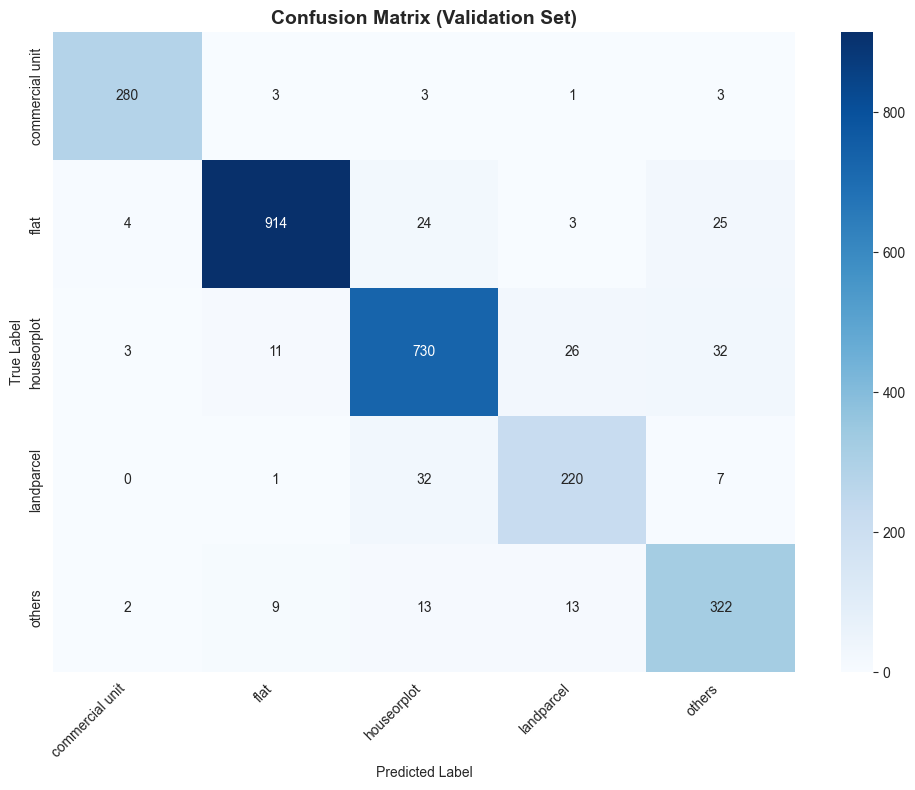

In [16]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
classes = sorted(train_df["categories"].unique())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix (Validation Set)", fontweight="bold", fontsize=14)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

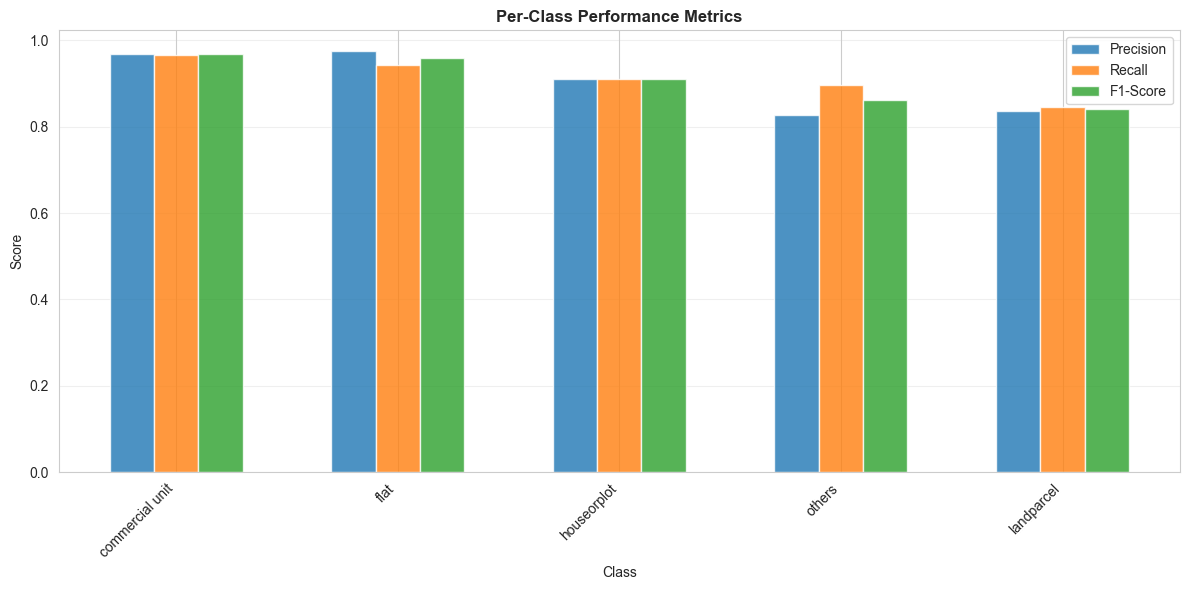


Best Performing Classes:
                 precision    recall  f1-score  support
commercial unit   0.968858  0.965517  0.967185    290.0
flat              0.974414  0.942268  0.958071    970.0
houseorplot       0.910224  0.910224  0.910224    802.0

Worst Performing Classes:
             precision    recall  f1-score  support
houseorplot   0.910224  0.910224  0.910224    802.0
others        0.827763  0.896936  0.860963    359.0
landparcel    0.836502  0.846154  0.841300    260.0


In [17]:
# Per-Class Analysis
report_dict = classification_report(y_val, y_val_pred, output_dict=True)
class_metrics = pd.DataFrame(report_dict).T.iloc[:-3]
class_metrics = class_metrics.sort_values("f1-score", ascending=False)

plt.figure(figsize=(12, 6))
x = range(len(class_metrics))
plt.bar([i-0.2 for i in x], class_metrics["precision"], 0.2, label="Precision", alpha=0.8)
plt.bar(x, class_metrics["recall"], 0.2, label="Recall", alpha=0.8)
plt.bar([i+0.2 for i in x], class_metrics["f1-score"], 0.2, label="F1-Score", alpha=0.8)
plt.xlabel("Class")
plt.ylabel("Score")
plt.title("Per-Class Performance Metrics", fontweight="bold")
plt.xticks(x, class_metrics.index, rotation=45, ha="right")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print("\nBest Performing Classes:")
print(class_metrics.head(3)[["precision", "recall", "f1-score", "support"]])
print("\nWorst Performing Classes:")
print(class_metrics.tail(3)[["precision", "recall", "f1-score", "support"]])

## Explainability Analysis (LIME)

**Why LIME?**
- Validates model is learning correct patterns
- Shows which keywords drive predictions
- Builds trust in model decisions


In [24]:
# Install LIME if needed
try:
    import lime
    from lime.lime_text import LimeTextExplainer
    print("LIME already installed")
except:
    import sys
    !{sys.executable} -m pip install lime -q
    from lime.lime_text import LimeTextExplainer
    print("LIME installed successfully")

LIME already installed


In [25]:
# Create LIME explainer
explainer = LimeTextExplainer(
    class_names=sorted(train_df["categories"].unique()),
    split_expression=' ',  # Split by spaces
    random_state=RANDOM_SEED
)

print("LIME explainer created")
print(f"   Classes: {explainer.class_names}")

LIME explainer created
   Classes: ['commercial unit', 'flat', 'houseorplot', 'landparcel', 'others']


In [28]:
# Select interesting examples (one per class)
print("Selecting representative examples...\n")

examples = {}
for cls in sorted(train_df["categories"].unique()):
    # Find a correctly predicted example
    mask = (y_val == cls) & (y_val_pred == cls)
    if mask.sum() > 0:
        idx = np.where(mask)[0][0]  # Get first correct prediction
        examples[cls] = {
            'text': X_val_raw[idx],
            'true': y_val[idx],
            'pred': y_val_pred[idx]
        }
        print(f"{cls:20s}: {X_val_raw[idx][:70]}...")

print(f"\nSelected {len(examples)} examples for analysis")

Selecting representative examples...

commercial unit     : Shop No. Ii 108 And Ii 36 Radha Raman Textile Market Saroli Poona Kumb...
flat                : Flat-A/402,Floor-4 Elenza Greens - Block A Plot 232/2,S No 805/B,Tp-3,...
houseorplot         : All That Piece And Parcel Of The Land Bearing Plot No. 141
 Admeasurin...
landparcel          : Patta No,57 Va 58,Khasra No 699,Village And Gp Malsisar,Tehsil Alsisar...
others              : Unit-900-Block-X Rajdhani Metropolis Village-Renwaltehsil-Phagi Jaipur...

Selected 5 examples for analysis


In [ ]:
# Define probability wrapper for LinearSVC
from scipy.special import softmax

def predict_proba_wrapper(texts):
    """Convert LinearSVC decision scores to probabilities.
    
    LinearSVC uses decision_function(), not predict_proba().
    We convert scores to probabilities using softmax.
    """
    scores = pipeline.decision_function(texts)
    return softmax(scores, axis=1)

print("Probability wrapper function created")

In [29]:
print("LIME EXPLAINABILITY ANALYSIS")
print("Using softmax(decision_function) for probabilities\n")

for cls, example in examples.items():
    text = example["text"]

    print(f"\n{'='*80}")
    print(f"CLASS: {cls.upper()}")
    print(f"{'='*80}")
    print(f"Address: {text[:100]}...")

    # Generate explanation
    exp = explainer.explain_instance(
        text,
        predict_proba_wrapper,
        num_features=8,
        num_samples=100
    )

    # Get predicted class
    pred_class = pipeline.predict([text])[0]
    pred_idx = explainer.class_names.index(pred_class)

    print(f"\nPredicted: '{pred_class}'")
    print(f"Top words influencing prediction:")

    try:
        explanation_list = exp.as_list(label=pred_idx)
        for word, weight in explanation_list:
            print(f"  {word:20s}: {weight:+.4f}")
    except KeyError:
        print(f"  Note: Showing explanation for top predicted class")
        for word, weight in exp.as_list():
            print(f"   {word:20s}: {weight:+.4f}")

print("\nLIME analysis complete")


LIME EXPLAINABILITY ANALYSIS
Using softmax(decision_function) for probabilities


CLASS: COMMERCIAL UNIT
Address: Shop No. Ii 108 And Ii 36 Radha Raman Textile Market Saroli Poona Kumbharia Road 847 Radha Raman Tex...

Predicted: 'commercial unit'
Top words influencing prediction:
  Note: Showing explanation for top predicted class
   Shop                : -0.1073
   No.                 : -0.0261
   Ii                  : +0.0240
   847                 : +0.0155
   Textile             : -0.0117
   Market              : -0.0105
   Raman               : +0.0090
   Poona               : +0.0071

CLASS: FLAT
Address: Flat-A/402,Floor-4 Elenza Greens - Block A Plot 232/2,S No 805/B,Tp-3,Elenza Greens, Opp.Laxminaraya...

Predicted: 'flat'
Top words influencing prediction:
  Flat-A/402,Floor-4  : +0.2916
  Ahmedabad           : +0.0577
  Plot                : -0.0550
  Block               : +0.0478
  Gujarat             : +0.0409
  Residendy,          : +0.0371
  232/2,S             : +0.0338

## Save Trained Model

Save the trained pipeline for future use

In [30]:
import os

# Try using cloudpickle (better for custom functions)
try:
    import cloudpickle
    use_cloudpickle = True
    print("Using cloudpickle for better function serialization")
except ImportError:
    import joblib
    use_cloudpickle = False
    print("cloudpickle not found, installing...")
    import sys
    !{sys.executable} -m pip install cloudpickle -q
    import cloudpickle
    use_cloudpickle = True
    print("cloudpickle installed successfully")


# Save the trained pipeline
model_path = "../best_models/svm_classifier_v2.pkl"

# Save using cloudpickle (handles notebook-defined functions)
with open(model_path, 'wb') as f:
    cloudpickle.dump(pipeline, f)

print(f"\n Model saved successfully to: {model_path}")
print(f"   File size: {os.path.getsize(model_path) / 1024:.2f} KB")
print(f"\nTo load the model later, use:")
print(f"   import cloudpickle")
print(f"   with open('{model_path}', 'rb') as f:")
print(f"       pipeline = cloudpickle.load(f)")

Using cloudpickle for better function serialization

 Model saved successfully to: ../best_models/svm_classifier_v2.pkl
   File size: 605.52 KB

To load the model later, use:
   import cloudpickle
   with open('../best_models/svm_classifier_v2.pkl', 'rb') as f:
       pipeline = cloudpickle.load(f)
